# Task 1 - Sentiment analysis

## Subtask 1.1

* Data retrieval
* Feature Extraction
* Feature Engineering
* EDA
* Model Evaluation
* Deployment



#### Installing contractions

In [1]:
pip install contractions

     |████████████████████████████████| 284 kB 14.2 MB/s 
     |████████████████████████████████| 321 kB 17.4 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85457 sha256=1b8d443ec9609a8778af76fdc675feeffa4c2a58eddaba0c77e079b7a4265498
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick


#### Importing the libraries

In [2]:
# Usual data representation and manipulation libraries
import pandas as pd
import numpy as np
from collections import Counter

# NLTK is very useful for natural language applications
import nltk

# This will be used to tokenize sentences
from nltk.tokenize.toktok import ToktokTokenizer

# We use spacy for extracting useful information from English words
import spacy
nlp = spacy.load('en', parse = False, tag=False, entity=False)

# This dictionary will be used to expand contractions (e.g. we'll -> we will)
from contractions import contractions_dict
import re

# Unicodedata will be used to remove accented characters
import unicodedata

# BeautifulSoup will be used to remove html tags
from bs4 import BeautifulSoup

# Lexicon models
from nltk.corpus import sentiwordnet as swn
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Evaluation libraries
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


## Importing the dataset and Pre-Processing

In [3]:
#importing the data set
#positive data set
positive_food_review = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Machine Learning/Applied AI/data/positive(1).csv")
#negative dataset
negative_food_review = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Machine Learning/Applied AI/data/negative(1).csv")

In [4]:
positive_food_review.head(5)

,Review,Label
0,Better than Wolff's Kasha. I grew up eating Ka...,1
1,It was such good product. Came in two differen...,1
2,MMMM Yes all chocolate is good.<br />But some ...,1
3,"This is, as all of their cereals I've ordered ...",1
4,Whoever Photoshopped the cookie on the front o...,1


In [5]:
negative_food_review.head(5)

,Review,Label
0,We love Malibu Rum but they sure missed the ma...,0
1,I just wanted to say that if you want to get y...,0
2,These seeds were accompanied by small broken p...,0
3,Way way way overpriced. I can get this same se...,0
4,I bought these on the strength of the reviews....,0


## EDA for positive and negative data

(array([2.2336e+04, 2.1960e+03, 3.1500e+02, 6.5000e+01, 6.2000e+01,
        1.4000e+01, 2.0000e+00, 6.0000e+00, 2.0000e+00, 2.0000e+00]),
 array([  33. ,  959.3, 1885.6, 2811.9, 3738.2, 4664.5, 5590.8, 6517.1,
        7443.4, 8369.7, 9296. ]),
 <a list of 10 Patch objects>)

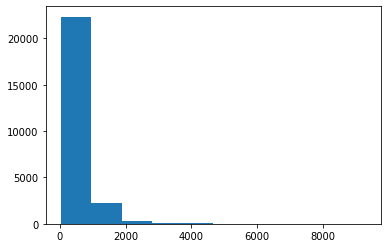

In [52]:
positive_food_review['review_len'] = positive_food_review['Review'].astype(str).apply(len)
plt.hist(negative_food_review['review_len'])

(array([2.2336e+04, 2.1960e+03, 3.1500e+02, 6.5000e+01, 6.2000e+01,
        1.4000e+01, 2.0000e+00, 6.0000e+00, 2.0000e+00, 2.0000e+00]),
 array([  33. ,  959.3, 1885.6, 2811.9, 3738.2, 4664.5, 5590.8, 6517.1,
        7443.4, 8369.7, 9296. ]),
 <a list of 10 Patch objects>)

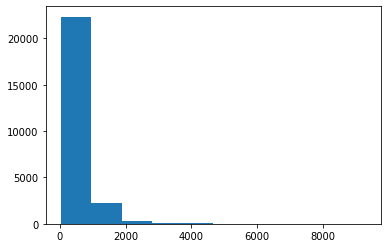

In [53]:
negative_food_review['review_len'] = negative_food_review['Review'].astype(str).apply(len)
plt.hist(negative_food_review['review_len'])

#### Printing the wordcloud for Positive reviews

There are 10536284 words in the combination of all positive reviews.


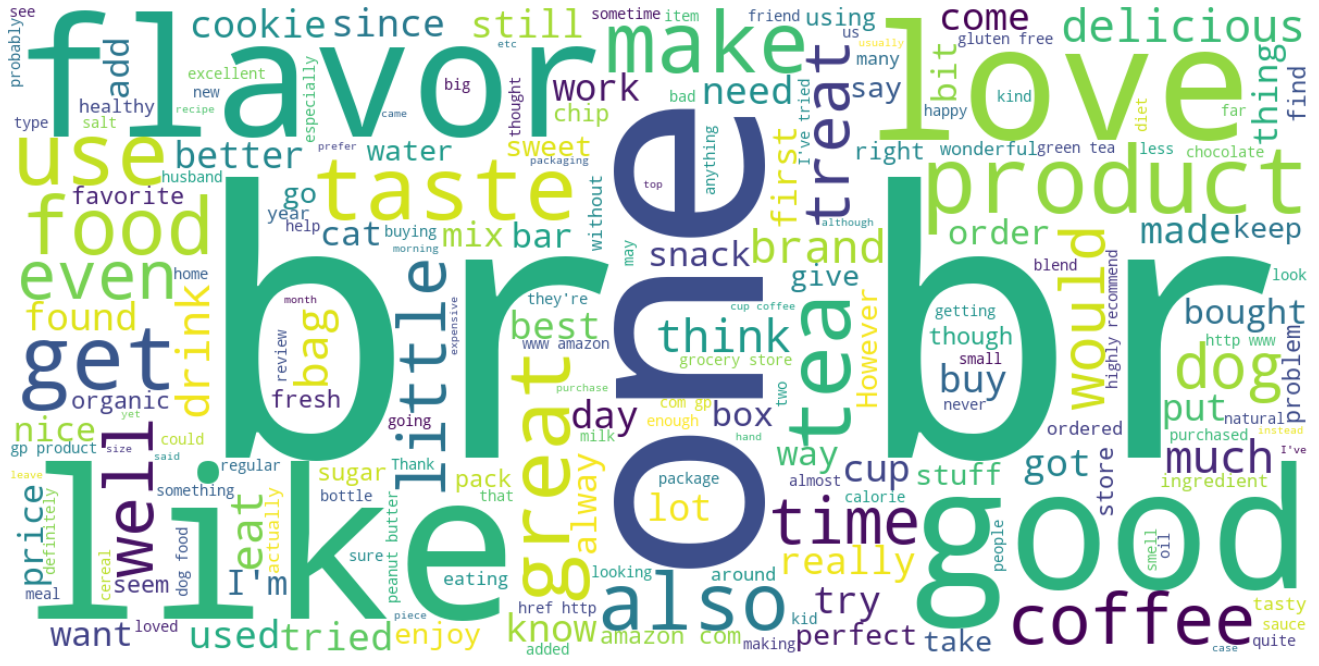

CPU times: user 12 s, sys: 399 ms, total: 12.4 s
Wall time: 13.8 s


In [12]:
%%time
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
text = " ".join(review for review in positive_food_review["Review"])
print ("There are {} words in the combination of all positive reviews.".format(len(text)))
# Create stopword list:
default_stopwords=set(stopwords.words('english'))

# Generate a word cloud image
wordcloud = WordCloud(stopwords=default_stopwords, background_color="white", width=1200, height=600).generate(text)

# Display the generated image:
plt.figure(figsize=(30,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Printing the wordcloud for Negative reviews

There are 12405252 words in the combination of all positive reviews.


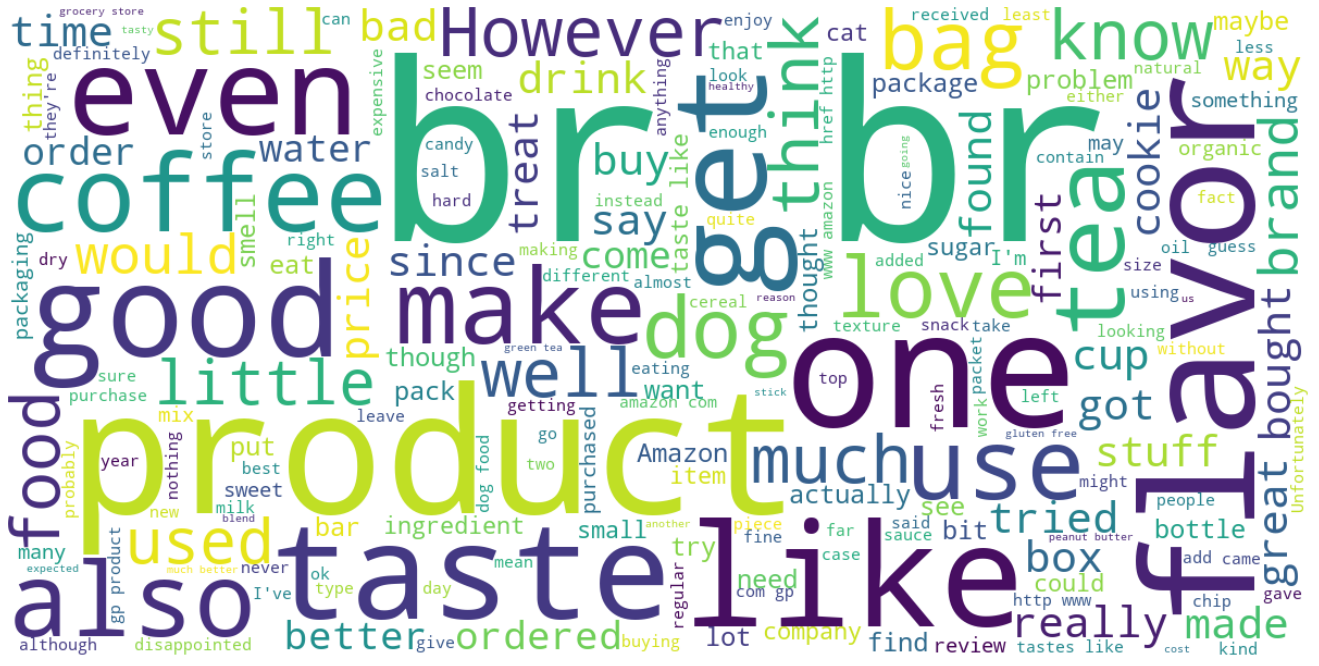

CPU times: user 9.87 s, sys: 352 ms, total: 10.2 s
Wall time: 10.2 s


In [13]:
%%time
text = " ".join(review for review in negative_food_review["Review"])
print ("There are {} words in the combination of all positive reviews.".format(len(text)))

# Generate a word cloud image
wordcloud = WordCloud(stopwords=default_stopwords, background_color="white", width=1200, height=600).generate(text)

# Display the generated image:
plt.figure(figsize=(30,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### In the data sample, we can notice that the text reviews contain html tag. The following code will use BeautifulSoup to remove those tags.

In [6]:
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

#### Also removing accented and special characters.

In [7]:
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def remove_special_characters(text):
    text = re.sub('[^a-zA-z0-9\s]', '', text)
    return text

#### Now using the contraction dictionary to expand them using regular expression

In [8]:
def expand_contractions(text, contraction_mapping=contractions_dict):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contractions_dict.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)

    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match) if contraction_mapping.get(match) else contraction_mapping.get(match.lower())                               
        return first_char+expanded_contraction[1:] if expanded_contraction != None else match
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

#### We may also need to lemmatize the words in a sentence, i.e. extract the canonical form of the words.

In [9]:
def lemmatize_text(text):
    text = nlp(text)
    return ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])

#### Downloading a list of stopwords  (list of words that are usually filtered before processing natural languages). Because we are concerned with sentiment prediction, it is very important to keep the polarity of the sentence, that is why we need to keep words like no or not.

In [10]:
nltk.download('stopwords')
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

def remove_stopwords(text, is_lower_case=False):
    tokenizer = ToktokTokenizer()
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Removing the repeated characters

In [14]:
# Ref : https://stackoverflow.com/a/37013006
def remove_words_with_repeated_characters(sentence): 
    pattern = re.compile("\\s*\\b(?=\\w*(\\w)\\1{2,})\\w*\\b")
    cleaned_text  = re.sub(pattern,' ',sentence)
    return (cleaned_text)

# sentence = "This looks soooooooo good! I am so happpyyy aa aaa aaaa"
# print("Sample")
# print(f"Before: {sentence}")
# print(f"After: {remove_words_with_repeated_characters(sentence)}")

#### Combining all the previous functions into a normalize_corpus function to apply the chosen pre-processing techniques

In [15]:
def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True, accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, stopword_removal=True, repeated_characters=True):
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # strip HTML
        if html_stripping:
            doc = strip_html_tags(doc)
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # expand contractions    
        if contraction_expansion:
            doc = expand_contractions(doc)
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # insert spaces between special characters to isolate them    
        special_char_pattern = re.compile(r'([{.(-)!}])')
        doc = special_char_pattern.sub(" \\1 ", doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters    
        if special_char_removal:
            doc = remove_special_characters(doc)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
        if repeated_characters:
            doc = remove_words_with_repeated_characters(doc)
            
        normalized_corpus.append(doc)
    return normalized_corpus

#### Lets combine both the data frames of positive and negative reviews

In [16]:
food_reviews = positive_food_review.append(negative_food_review, ignore_index=True)

In [17]:
food_reviews.head()

,Review,Label
0,Better than Wolff's Kasha. I grew up eating Ka...,1
1,It was such good product. Came in two differen...,1
2,MMMM Yes all chocolate is good.<br />But some ...,1
3,"This is, as all of their cereals I've ordered ...",1
4,Whoever Photoshopped the cookie on the front o...,1


#### The following code snippet to convert and save the processed dataset or use the normalized_food_reviews.csv file directly. This step may take some time to be completed.

In [15]:
# normal_food_reviews = pd.DataFrame()
# normal_food_reviews['reviews'] = normalize_corpus(food_reviews.Review)
# normal_food_reviews.to_csv("normalized_food_reviews.csv", index = False)

In [18]:
normalized_food_reviews = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Machine Learning/Applied AI/data/normalized_food_reviews.csv")
normalized_food_reviews.head(5)

,reviews
0,well wolff kasha grow eat kasha easy prepare h...
1,good product come two different box describe c...
2,yes chocolate good chocolate well well choco...
3,cereal order far fresh high quality wonderful ...
4,whoever photoshoppe cookie front package true ...


### Concatenating the label to normalized dataframe 

In [19]:
normalized_food_reviews['labels'] = food_reviews['Label']

In [20]:
normalized_food_reviews.head()

,reviews,labels
0,well wolff kasha grow eat kasha easy prepare h...,1
1,good product come two different box describe c...,1
2,yes chocolate good chocolate well well choco...,1
3,cereal order far fresh high quality wonderful ...,1
4,whoever photoshoppe cookie front package true ...,1


#### Checking for duplicate values

In [21]:
pip install PrettyTable

#### Counting the total percentage of duplicate values

In [22]:
from prettytable import PrettyTable
mask_duplicated_reviews = normalized_food_reviews.duplicated(subset=["reviews"], keep='first')
count_duplicated_reviews = mask_duplicated_reviews.value_counts()

sum_reviews = count_duplicated_reviews.sum()
perc_duplicated_reviews = (count_duplicated_reviews/sum_reviews) * 100

x = PrettyTable()
x.field_names = ["","Count","Percentage of Total"]
x.add_rows([
    ["Duplicate Reviews", count_duplicated_reviews[True], perc_duplicated_reviews[True]],
    ["Original Reviews", count_duplicated_reviews[False], perc_duplicated_reviews[False]],
])
print(x)

+-------------------+-------+---------------------+
|                   | Count | Percentage of Total |
+-------------------+-------+---------------------+
| Duplicate Reviews |  4586 |  9.171999999999999  |
|  Original Reviews | 45414 |        90.828       |
+-------------------+-------+---------------------+


## Sentiment prediction 

In [23]:
# Usual data representation and manipulation libraries
import pandas as pd
import numpy as np

# ML Models
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import train_test_split

# Evaluation libraries
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Libraries for feature engineering
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [25]:
reviews = np.array(normalized_food_reviews['reviews'])
labels = np.array(normalized_food_reviews['labels'])

## Computing BOW and TF-IDF features

In [26]:
# extract data for model evaluation
train_reviews, test_reviews, train_labels, test_labels = train_test_split(reviews, labels, test_size=0.3, random_state=42)

# build BOW features on train reviews
cv = CountVectorizer(binary=False, min_df=0.0, max_df=1.0, ngram_range=(1,2))
cv_train_features = cv.fit_transform(train_reviews)

# build TFIDF features on train reviews
tv = TfidfVectorizer(use_idf=True, min_df=0.0, max_df=1.0, ngram_range=(1,2),sublinear_tf=True)
tv_train_features = tv.fit_transform(train_reviews)

In [27]:
# transform test reviews into features
cv_test_features = cv.transform(test_reviews)
tv_test_features = tv.transform(test_reviews)

In [28]:
print('BOW model:> Train features shape:', cv_train_features.shape, ' Test features shape:', cv_test_features.shape)
print('TFIDF model:> Train features shape:', tv_train_features.shape, ' Test features shape:', tv_test_features.shape)

BOW model:> Train features shape: (35000, 623887)  Test features shape: (15000, 623887)
TFIDF model:> Train features shape: (35000, 623887)  Test features shape: (15000, 623887)


## Model Training, Prediction and Performance Evaluation

* Logistic regression with BOW and TF-IDF word features
* Support vector machine with BOW and TF-IDF word features

In [29]:
# We define our SVM and LR models
lr = LogisticRegression(penalty='l2', max_iter=1000)
svm = SGDClassifier(loss='modified_huber', max_iter=100)

#### Logistic Regression model on BOW features

In [30]:
# Logistic Regression model on BOW features
lr.fit(cv_train_features,train_labels)
y_predicted = lr.predict(cv_test_features)

print("The model accuracy score is: {}".format(accuracy_score(test_labels, y_predicted)))
print("The model precision score is: {}".format(precision_score(test_labels, y_predicted, average="weighted")))
print("The model recall score is: {}".format(recall_score(test_labels, y_predicted, average="weighted")))
print("The model F1-score is: {}".format(f1_score(test_labels, y_predicted, average="weighted")))

print(classification_report(test_labels, y_predicted))

display(pd.DataFrame(confusion_matrix(test_labels, y_predicted), columns=["Pred. negative", "Pred. positive"], 
                     index=["Act. negative", "Act. positive"]))

The model accuracy score is: 0.8758666666666667
The model precision score is: 0.8758696920873612
The model recall score is: 0.8758666666666667
The model F1-score is: 0.8758655477813009
              precision    recall  f1-score   support

           0       0.88      0.87      0.88      7474
           1       0.88      0.88      0.88      7526

    accuracy                           0.88     15000
   macro avg       0.88      0.88      0.88     15000
weighted avg       0.88      0.88      0.88     15000



,Pred. negative,Pred. positive
Act. negative,6530,944
Act. positive,918,6608


#### Logistic Regression model on TF-IDF features

In [31]:
# Logistic Regression model on TF-IDF features
lr.fit(tv_train_features,train_labels)
y_predicted = lr.predict(tv_test_features)

print("The model accuracy score is: {}".format(accuracy_score(test_labels, y_predicted)))
print("The model precision score is: {}".format(precision_score(test_labels, y_predicted, average="weighted")))
print("The model recall score is: {}".format(recall_score(test_labels, y_predicted, average="weighted")))
print("The model F1-score is: {}".format(f1_score(test_labels, y_predicted, average="weighted")))

print(classification_report(test_labels, y_predicted))

display(pd.DataFrame(confusion_matrix(test_labels, y_predicted), columns=["Pred. negative", "Pred. positive"], 
                     index=["Act. negative", "Act. positive"]))

The model accuracy score is: 0.8680666666666667
The model precision score is: 0.868225115272761
The model recall score is: 0.8680666666666667
The model F1-score is: 0.8680579006341517
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      7474
           1       0.88      0.86      0.87      7526

    accuracy                           0.87     15000
   macro avg       0.87      0.87      0.87     15000
weighted avg       0.87      0.87      0.87     15000



,Pred. negative,Pred. positive
Act. negative,6560,914
Act. positive,1065,6461


#### SVM model on BOW

In [32]:
# SVM model on BOW
svm.fit(cv_train_features,train_labels)
y_predicted = svm.predict(cv_test_features)

print("The model accuracy score is: {}".format(accuracy_score(test_labels, y_predicted)))
print("The model precision score is: {}".format(precision_score(test_labels, y_predicted, average="weighted")))
print("The model recall score is: {}".format(recall_score(test_labels, y_predicted, average="weighted")))
print("The model F1-score is: {}".format(f1_score(test_labels, y_predicted, average="weighted")))

print(classification_report(test_labels, y_predicted))

display(pd.DataFrame(confusion_matrix(test_labels, y_predicted), columns=["Pred. negative", "Pred. positive"], index=["Act. negative", "Act. positive"]))

The model accuracy score is: 0.8538666666666667
The model precision score is: 0.8545253120344648
The model recall score is: 0.8538666666666667
The model F1-score is: 0.8538117110451557
              precision    recall  f1-score   support

           0       0.84      0.87      0.86      7474
           1       0.87      0.83      0.85      7526

    accuracy                           0.85     15000
   macro avg       0.85      0.85      0.85     15000
weighted avg       0.85      0.85      0.85     15000



,Pred. negative,Pred. positive
Act. negative,6537,937
Act. positive,1255,6271


#### SVM model on TF-IDF

In [33]:
#SVM model on TF-IDF
svm.fit(tv_train_features,train_labels)
y_predicted = svm.predict(tv_test_features)

print("The model accuracy score is: {}".format(accuracy_score(test_labels, y_predicted)))
print("The model precision score is: {}".format(precision_score(test_labels, y_predicted, average="weighted")))
print("The model recall score is: {}".format(recall_score(test_labels, y_predicted, average="weighted")))
print("The model F1-score is: {}".format(f1_score(test_labels, y_predicted, average="weighted")))

print(classification_report(test_labels, y_predicted))

display(pd.DataFrame(confusion_matrix(test_labels, y_predicted), columns=["Pred. negative", "Pred. positive"], index=["Act. negative", "Act. positive"]))

The model accuracy score is: 0.8816666666666667
The model precision score is: 0.8818132741672903
The model recall score is: 0.8816666666666667
The model F1-score is: 0.8816598225406984
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      7474
           1       0.89      0.87      0.88      7526

    accuracy                           0.88     15000
   macro avg       0.88      0.88      0.88     15000
weighted avg       0.88      0.88      0.88     15000



,Pred. negative,Pred. positive
Act. negative,6658,816
Act. positive,959,6567


## Supervised model on LSTM

In [34]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout, SpatialDropout1D
from tensorflow.keras.layers import LSTM
from nltk.tokenize.toktok import ToktokTokenizer

#### Tokenizing the inputs



In [35]:
# tokenize reviews
tokenizer = ToktokTokenizer()
tokenized_train = [tokenizer.tokenize(text) for text in train_reviews]
tokenized_test = [tokenizer.tokenize(text) for text in test_reviews]

#Building word to index vocabulary
token_counter = Counter([token for review in tokenized_train for token in review])
vocab_map = {item[0]: index+1 for index, item in enumerate(dict(token_counter).items())}
max_index = np.max(list(vocab_map.values()))
vocab_map['PAD_INDEX'] = 0
vocab_map['NOT_FOUND_INDEX'] = max_index+1
vocab_size = len(vocab_map)
# view vocabulary size and part of the vocabulary map
print('Vocabulary Size:', vocab_size)
print('Sample slice of vocabulary map:', dict(list(vocab_map.items())[10:20]))

Vocabulary Size: 32863
Sample slice of vocabulary map: {'nice': 11, 'also': 12, 'fairly': 13, 'cheap': 14, 'subscribe': 15, 'save': 16, 'option': 17, 'like': 18, 'medium': 19, 'roast': 20}


In [36]:
# get max length of train corpus
max_len = np.max([len(review) for review in tokenized_train])

# Convert tokenized text reviews to numeric vectors
train_X = [[vocab_map[token] for token in tokenized_review] for tokenized_review in tokenized_train]
train_X = sequence.pad_sequences(train_X, maxlen=max_len) # pad 
test_X = [[vocab_map[token] if vocab_map.get(token) else vocab_map['NOT_FOUND_INDEX'] 
           for token in tokenized_review] 
              for tokenized_review in tokenized_test]
test_X = sequence.pad_sequences(test_X, maxlen=max_len)

print('Max length of train review vectors:', max_len)
print('Train review vectors shape:', train_X.shape, ' Test review vectors shape:', test_X.shape)

Max length of train review vectors: 910
Train review vectors shape: (35000, 910)  Test review vectors shape: (15000, 910)


In [37]:
EMBEDDING_DIM = 128 # dimension for dense embeddings for each token
LSTM_DIM = 64 # total LSTM units

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, input_length=max_len))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(LSTM_DIM, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation="relu"))

model.compile(loss="binary_crossentropy", optimizer="adam",metrics=["accuracy"])

In [38]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 910, 128)          4206464   
                                                                 
 spatial_dropout1d (SpatialD  (None, 910, 128)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 4,255,937
Trainable params: 4,255,937
Non-trainable params: 0
_________________________________________________________________
None


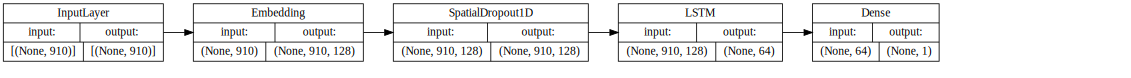

In [39]:
# Plotting librairies
from IPython.display import SVG
import tensorflow as tf
SVG(tf.keras.utils.model_to_dot(model, show_shapes=True, show_layer_names=False, rankdir='LR', dpi=60).create(prog='dot', format='svg'))

#### Training and Evaluating the Model

In [54]:
batch_size = 100
model.fit(train_X, train_labels, epochs=5, batch_size=batch_size, shuffle=True, validation_split=0.1, verbose=1)

Epoch 1/5
315/315 [==============================] - 685s 2s/step - loss: 0.6435 - accuracy: 0.6888 - val_loss: 0.5435 - val_accuracy: 0.7274
Epoch 2/5
315/315 [==============================] - 679s 2s/step - loss: 0.4590 - accuracy: 0.8041 - val_loss: 0.4520 - val_accuracy: 0.8297
Epoch 3/5
315/315 [==============================] - 677s 2s/step - loss: 0.3651 - accuracy: 0.8670 - val_loss: 0.8599 - val_accuracy: 0.5506
Epoch 4/5
315/315 [==============================] - 694s 2s/step - loss: 0.3917 - accuracy: 0.8321 - val_loss: 0.7360 - val_accuracy: 0.6480
Epoch 5/5
315/315 [==============================] - 675s 2s/step - loss: 0.3699 - accuracy: 0.8579 - val_loss: 0.6761 - val_accuracy: 0.8249


In [55]:
pred_test = model.predict(test_X)
pred = [0 if x<=0.5 else 1 for x in pred_test]

In [56]:
y_predicted = pred

print("The model accuracy score is: {}".format(accuracy_score(test_labels, y_predicted)))
print("The model precision score is: {}".format(precision_score(test_labels, y_predicted, average="weighted")))
print("The model recall score is: {}".format(recall_score(test_labels, y_predicted, average="weighted")))
print("The model F1-score is: {}".format(f1_score(test_labels, y_predicted, average="weighted")))

print(classification_report(test_labels, y_predicted))

display(pd.DataFrame(confusion_matrix(test_labels, y_predicted), columns=["Pred. negative", "Pred. positive"], index=["Act. negative", "Act. positive"]))

The model accuracy score is: 0.8254666666666667
The model precision score is: 0.8255915374544626
The model recall score is: 0.8254666666666667
The model F1-score is: 0.8254420536002367
              precision    recall  f1-score   support

           0       0.83      0.81      0.82      7474
           1       0.82      0.84      0.83      7526

    accuracy                           0.83     15000
   macro avg       0.83      0.83      0.83     15000
weighted avg       0.83      0.83      0.83     15000



,Pred. negative,Pred. positive
Act. negative,6088,1386
Act. positive,1232,6294


## Dumping the pickl file and requirement.txt for model deployment 

In [57]:
import pickle #credits to stack overflow user= blender

pickle.dump(lr, open('model.pkl', 'wb'))
pickle.dump(tv, open('tv_transform.pkl', 'wb'))

In [58]:
!pip list --format=freeze > requirements.txt

# References


1 - naushads (2021). [1/2]Amazon Fine Food Reviews-EDA,Data Cleaning,FE. [online] Kaggle.com. Available at: https://www.kaggle.com/naushads/1-2-amazon-fine-food-reviews-eda-data-cleaning-fe/notebook#EDA-2-(After-Data-Cleaning,-FE1) [Accessed 15 Dec. 2021].

‌